# CRSP Treasury Data Oveview

The CRSP US Treasury Database is a comprehensive source of historical Treasury security data maintained by the Center for Research in Security Prices at the University of Chicago's Booth School of Business. This section provides an essential overview of this critical dataset, which will serve as the foundation for our subsequent replication of the Gürkaynak, Sack, and Wright (2006) & Waggoner (1997) yield curve estimation methodologies.


## Database Description

The CRSP US Treasury Database provides complete historical descriptive information and market data for US Treasury securities, including:

- Prices
- Returns
- Accrued interest
- Yields
- Durations

The database begins in 1961 and is updated monthly. The data is available in ASCII, Excel, and SAS formats.

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

ROOT = Path.cwd()
DATA_DIR = ROOT.parent / '_data'
OUTPUT_DIR = ROOT.parent / '_output'

TREASURY_FILES = [
    'TFZ_consolidated.parquet',
    'TFZ_DAILY.parquet',
    'TFZ_INFO.parquet',
    'TFZ_with_runness.parquet'
]

for file in TREASURY_FILES:
    df = pd.read_parquet(DATA_DIR / file)
    print(f'Columns in {file}: {df.columns.tolist()}')

Columns in TFZ_consolidated.parquet: ['kytreasno', 'kycrspid', 'tcusip', 'mcaldt', 'tdatdt', 'tmatdt', 'tfcaldt', 'tmbid', 'tmask', 'tmaccint', 'tmyld', 'price', 'tcouprt', 'itype', 'original_maturity', 'iflwr', 'years_to_maturity', 'tmduratn', 'tmretnua', 'days_to_maturity', 'callable']
Columns in TFZ_DAILY.parquet: ['kytreasno', 'kycrspid', 'mcaldt', 'tmbid', 'tmask', 'tmaccint', 'tmyld', 'price']
Columns in TFZ_INFO.parquet: ['kytreasno', 'kycrspid', 'tcusip', 'tdatdt', 'tmatdt', 'tcouprt', 'itype', 'original_maturity']
Columns in TFZ_with_runness.parquet: ['kytreasno', 'kycrspid', 'tcusip', 'mcaldt', 'tdatdt', 'tmatdt', 'tfcaldt', 'tmbid', 'tmask', 'tmaccint', 'tmyld', 'price', 'tcouprt', 'itype', 'original_maturity', 'iflwr', 'years_to_maturity', 'tmduratn', 'tmretnua', 'days_to_maturity', 'callable', 'run']


## 1. Raw CRSP Treasury Inputs
The CRSP US Treasury database is delivered in several "building block" files:
- `TFZ_DAILY`: daily quotes
- `TFZ_INFO`: bond characteristics
- `TFZ_consolidated`: merged quotes + characteristics
- `TFZ_with_runness`: merged quotes + characteristics + runness indicators

For our analysis, we will focus on the `TFZ_with_runness` file, as it contains all of the required fields for curve estimation in one location: quotes, bond characteristics, duration, maturity, and runness.  

In [ ]:
#Peek at the TFZ_with_runness raw file
tfz_with_runness_raw = pd.read_parquet(DATA_DIR / 'TFZ_with_runness.parquet')
display(tfz_with_runness_raw.head())

,kytreasno,kycrspid,tcusip,mcaldt,tdatdt,tmatdt,tfcaldt,tmbid,tmask,tmaccint,...,tcouprt,itype,original_maturity,iflwr,years_to_maturity,tmduratn,tmretnua,days_to_maturity,callable,run
0,200641.0,19700312.400000,912793DC,1970-02-27,1969-09-10,1970-03-12,0,99.763474,99.787666,0.000000,...,0.0,4.0,1.0,1.0,0.0,13.0,0.006565,13,False,0
1,200634.0,19700205.400000,912793CW,1970-01-30,1969-08-07,1970-02-05,0,99.866669,99.883331,0.000000,...,0.0,4.0,0.0,1.0,0.0,6.0,0.006100,6,False,0
2,200635.0,19700213.400000,912793CX,1970-01-30,1969-08-14,1970-02-13,0,99.700554,99.727776,0.000000,...,0.0,4.0,1.0,1.0,0.0,14.0,0.006317,14,False,0
3,200636.0,19700215.104000,912810AE,1970-01-30,1965-01-15,1970-02-15,0,99.968750,100.031250,1.826087,...,4.0,1.0,5.0,1.0,0.0,16.0,0.008491,16,False,0
4,200637.0,19700219.400000,912793CY,1970-01-30,1969-08-21,1970-02-19,0,99.580559,99.610001,0.000000,...,0.0,4.0,0.0,1.0,0.0,20.0,0.006479,20,False,0


### Key columns we care about downstream:
The cleaning code focuses on:
- **Identifiers:** date, CUSIP, CRSP IDs
- **Bond characteristics:** coupon, issue date, maturity date, instrument type
- **Quotes:** bid, ask, yield, accrued interest
- **Maturity measures:** time-to-maturity in days/years
- **Runness:** on-the-run / off-the-run indicators (used for sample selection)

In [13]:
#compact overview
tfz_compact = (
    tfz_with_runness_raw.dtypes
    .astype(str)
    .reset_index()
    .rename(columns={'index': 'column', 0: 'dtype'})
    .sort_values('column')
    .reset_index(drop=True)
)
display(tfz_compact)

,column,dtype
0,callable,bool
1,days_to_maturity,int64
2,iflwr,float64
3,itype,float64
4,kycrspid,object
5,kytreasno,float64
6,mcaldt,datetime64[ns]
7,original_maturity,float64
8,price,float64
9,run,int64


# 2. Cleaning Pipeline via `tidy_CRSP_treasury.py`

The file `tidy_CRSP_treasury.py` implements a small explicit pipeline to prepare the `TFZ_with_runness.parquet` file for curve estimation via the following steps:
1. Load*`TFZ_with_runness.parquet`
2. Standardize column names (rename CRSP-style names to readable ones)
3. Add derived fields used in later curve work:
   - mid price = (bid + ask) / 2  
   - time-to-maturity (days & years)
   - sanity-check flags (valid quotes, nonnegative maturity)
   - runness indicators (on-the-run, first-off, off-the-run)
   - maturity flags (<30d, <3m, <1y, 20y post-1996)
   - instrument type flags (bond/note/bill) and “flower bond” flag
4. Select the minimal relevant columns
5. Write `tidy_CRSP_treasury.parquet` to the project output directory

### Run the pipeline end-to-end:

In [7]:
import tidy_CRSP_treasury
tidy_CRSP_treasury.main(DATA_DIR, OUTPUT_DIR)
df_tidy = pd.read_parquet(OUTPUT_DIR / "tidy_CRSP_treasury.parquet")
display(df_tidy.head())

Wrote tidy CRSP Treasury data set saved to: /Users/phoebefingold/FINM_Repo/FINM_32900/p14_gurkaynak_sack_wright_2007/_output/tidy_CRSP_treasury.parquet


,date,cusip,kytreasno,kycrspid,issue_date,maturity_date,coupon,itype,iflwr,run,...,is_under_1y,is_20y,is_20yr_post_1996,is_bond,is_note,is_bill,is_flower,valid_quote,nonnegative_maturity,clean
0,1970-01-30,912793BQ,200639.0,19700228.400000,1969-02-27,1970-02-28,0.0,4.0,1.0,0,...,True,False,False,False,False,True,False,True,True,True
1,1970-01-30,912793BR,200646.0,19700331.400000,1969-04-01,1970-03-31,0.0,4.0,1.0,0,...,True,False,False,False,False,True,False,True,True,True
2,1970-01-30,912793CG,200653.0,19700430.400000,1969-04-29,1970-04-30,0.0,4.0,1.0,0,...,True,False,False,False,False,True,False,True,True,True
3,1970-01-30,912793CH,200660.0,19700531.400000,1969-05-29,1970-05-31,0.0,4.0,1.0,0,...,True,False,False,False,False,True,False,True,True,True
4,1970-01-30,912793CU,200666.0,19700630.400000,1969-06-26,1970-06-30,0.0,4.0,1.0,0,...,True,False,False,False,False,True,False,True,True,True


### Step-by-step tour via Intermediate DataFrames

Below we walk through the exact functions of `tidy_CRSP_treasury.py` to demonstrate how the raw data gets transformed into the curve estimation-ready data

In [15]:
df0 = tidy_CRSP_treasury.load_CRSP_treasury_data(DATA_DIR)
df1 = tidy_CRSP_treasury.standardize_column_names(df0)
df2 = tidy_CRSP_treasury.add_relevant_fields(df1)
df3 = tidy_CRSP_treasury.select_relevant_cols(df2)

print("TFZ raw:", df0.shape)
print("standardized:", df1.shape)
print("with derived fields:", df2.shape)
print("selected cols (tidy):", df3.shape)

df3.head()

TFZ raw: (145747, 22)
standardized: (145747, 22)
with derived fields: (145747, 38)
selected cols (tidy): (145747, 34)


,date,cusip,kytreasno,kycrspid,issue_date,maturity_date,coupon,itype,iflwr,run,...,is_under_1y,is_20y,is_20yr_post_1996,is_bond,is_note,is_bill,is_flower,valid_quote,nonnegative_maturity,clean
6,1970-01-30,912793BQ,200639.0,19700228.400000,1969-02-27,1970-02-28,0.0,4.0,1.0,0,...,True,False,False,False,False,True,False,True,True,True
14,1970-01-30,912793BR,200646.0,19700331.400000,1969-04-01,1970-03-31,0.0,4.0,1.0,0,...,True,False,False,False,False,True,False,True,True,True
27,1970-01-30,912793CG,200653.0,19700430.400000,1969-04-29,1970-04-30,0.0,4.0,1.0,0,...,True,False,False,False,False,True,False,True,True,True
54,1970-01-30,912793CH,200660.0,19700531.400000,1969-05-29,1970-05-31,0.0,4.0,1.0,0,...,True,False,False,False,False,True,False,True,True,True
78,1970-01-30,912793CU,200666.0,19700630.400000,1969-06-26,1970-06-30,0.0,4.0,1.0,0,...,True,False,False,False,False,True,False,True,True,True


## 3. Sanity Checks

The cleaning step creates a few flags that prevent downstream errors:

- `valid_quote`: bid/ask are finite, positive, and `ask >= bid`
- `nonnegative_maturity`: time-to-maturity is finite and nonnegative
- `clean`: conjunction of the above

These are not necessarily “final sample selection” rules. Rather, they help ensure we can safely compute mid prices, maturities, and do curve estimation without obvious data errors.

In [18]:
#Check problematic rows (if they exist)
problematic_rows = df2.loc[~df2['clean'], ['date', 'cusip', 'bid', 'ask','maturity_date', 'ttm_days', 'valid_quote', 'nonnegative_maturity']]
display(problematic_rows.head())


,date,cusip,bid,ask,maturity_date,ttm_days,valid_quote,nonnegative_maturity


Above, we observe that the cleaning process removed all problematic datapoitns.

## 4. Runness Indicators & Maturity Flags

In our cleaning process, we added runness indicators & maturity flags to easily align with GSW and Waggoners' estimation processes:

Runness Indicators:
- `is_on_the_run`: `run == 0`
- `is_first_off_the_run`: `run == 1`
- `is_off_the_run`: `run >= 2`

Maturity Flags:
- We also create maturity flags (e.g., `<30d`, `<1y`) that are common in curve estimation sample rules (many papers exclude ultra-short maturities, and some handle 20-year reintroductions separately).


In [20]:
#Shares by runness category
runness_shares = pd.Series({
    'is_on_the_run': df2['is_on_the_run'].mean(),
    'is_first_off_the_run': df2['is_first_off_the_run'].mean(),
    'is_off_the_run': df2['is_off_the_run'].mean(),
})
display(runness_shares.to_frame('share'))

,share
is_on_the_run,0.122438
is_first_off_the_run,0.035603
is_off_the_run,0.841959


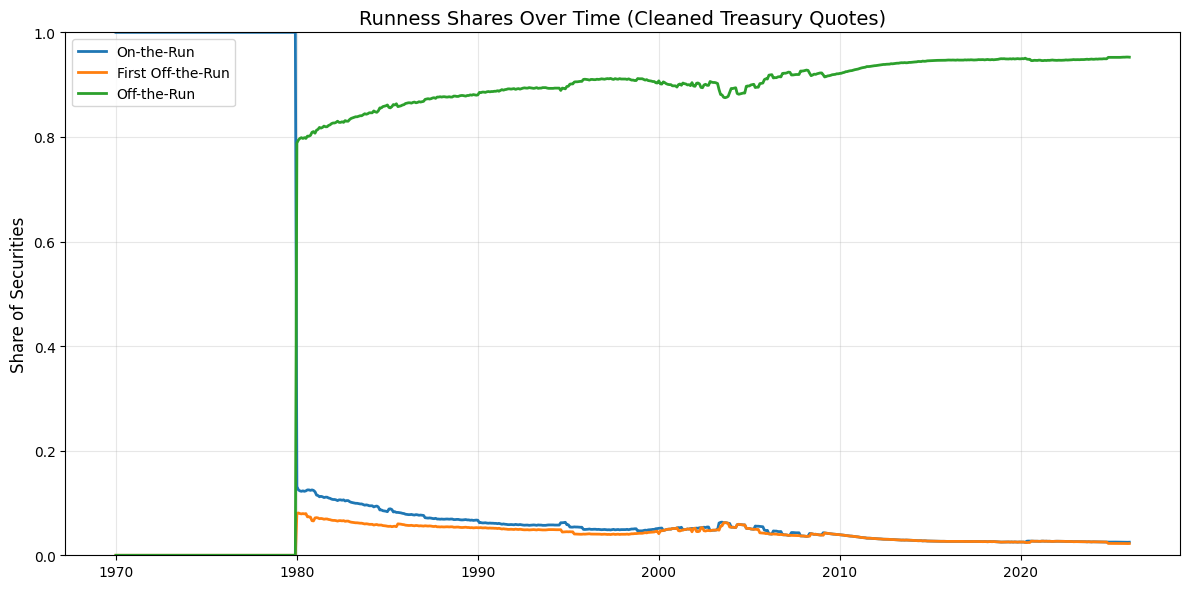

In [26]:
#Shares over time (monthly)
tmp = df2.loc[df2['clean']].copy()
tmp['month'] = pd.to_datetime(tmp['date']).dt.to_period('M').dt.to_timestamp()
monthly = tmp.groupby('month')[['is_on_the_run', 'is_first_off_the_run', 'is_off_the_run']].mean()

fig, ax = plt.subplots(figsize=(12,6))

ax.plot(monthly.index, monthly['is_on_the_run'], label='On-the-Run', linewidth=2)
ax.plot(monthly.index, monthly['is_first_off_the_run'], label='First Off-the-Run', linewidth=2)
ax.plot(monthly.index, monthly['is_off_the_run'], label='Off-the-Run', linewidth=2)

ax.set_title('Runness Shares Over Time (Cleaned Treasury Quotes)', fontsize=14)
ax.set_ylabel('Share of Securities', fontsize=12)
ax.set_xlabel('')

ax.set_ylim(0,1)
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

Above, we observe how before the early 1980s, all cleaned quotes are classified as "on-the-run." This reflects limitations in historical issuance coverage & runnness identification in the early CRSP data. After 1980, the cross-section stabilizes, with ~80-95% of bonds off-the-run, and small shares of on-the-run and first-off-the-run securities.

## 5. Yield Curve Snapshot

To connect our cleaned dataset to the analysis code, we can build a quick yield curve snapshot figure via GSW's implementation. This is **not** a full GSW curve estimation, but it illustrates why we want clean maturities, clean quotes, and runness labels for estimation.

snapshot date: 2026-01-30
number of securities: 368


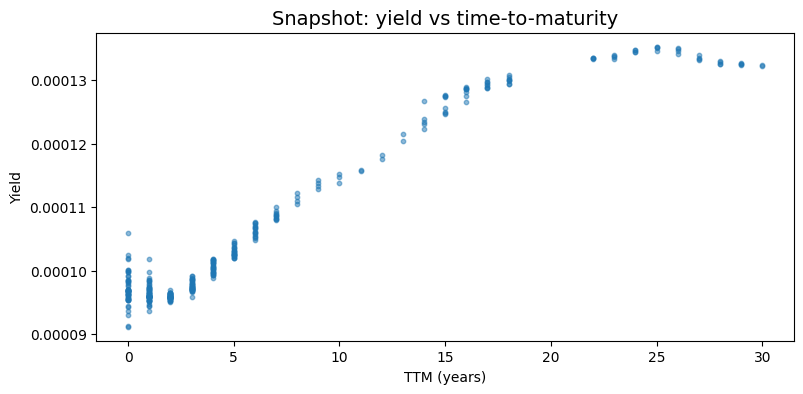

In [27]:
# Choose a representative date (latest in sample)
snap_date = pd.to_datetime(df_tidy['date']).max()
snap = df_tidy.loc[pd.to_datetime(df_tidy['date']) == snap_date].copy()

# Basic "safe" screen for plotting
snap = snap.loc[
    snap['clean'] &
    (~snap['is_flower']) &
    (~snap['is_under_30d']) &
    (~snap['is_20yr_post_1996'])
]

print('snapshot date:', snap_date.date())
print('number of securities:', len(snap))

# Scatter: yield vs maturity (years)
fig, ax = plt.subplots(figsize=(9,4))
ax.scatter(snap['ttm_years'], snap['yield'], s=10, alpha=0.5, label='all (screened)')
ax.set_title('Snapshot: yield vs time-to-maturity', fontsize=14)
ax.set_xlabel('TTM (years)')
ax.set_ylabel('Yield')
plt.show()

The first figure plots yield against time-to-maturity for all screened securities on the most recent date in the sample. Several features confirm the integrity of the cleaned dataset:

- The cross section spans the full maturity spectrum, confirming that the time-to-maturity calculation and maturity filtering steps in the pipeline are functioning as intended
- The curve has a smooth upward-sloping shape across most maturities, consistent with a typical positive term premium environment
- An absence of extreme outliers or discontinuities reflects the effectiveness of the cleaning flags
- Tight clustering of points at key maturity buckets reflects Treasury issuance conventions

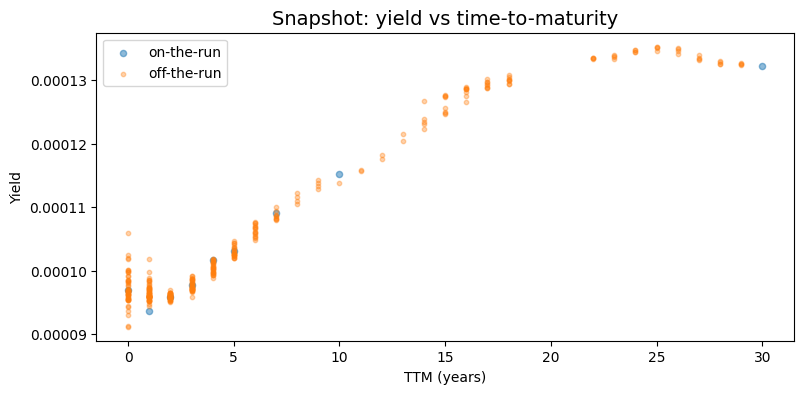

In [30]:
#on-the-run vs off-the-run on same snapshot
fig, ax = plt.subplots(figsize=(9,4))
on = snap.loc[snap['is_on_the_run']]
off = snap.loc[snap['is_off_the_run']]
ax.scatter(on['ttm_years'], on['yield'], s=20, alpha=0.5, label='on-the-run')
ax.scatter(off['ttm_years'], off['yield'], s=10, alpha=0.35, label='off-the-run')
ax.set_title('Snapshot: yield vs time-to-maturity', fontsize=14)
ax.set_xlabel('TTM (years)')
ax.set_ylabel('Yield')
ax.legend()
plt.show()

The second figure separates on-the-run and off-the-run securities within the same snapshot and highlights one of our motivations for constructing runness classifications in the cleaning pipeline. On-the-run securities are fewer in number and typically cluster at standard benchmark maturities. Off-the-run securities are much more numerous and fill in the maturity spectrum between benchmarks. In many maturity buckets, off-the-run securities exhibit slightly higher yields relative to nearby on-the-run bonds. This cross-sectional dispersion is exactly why runnness indicators are valuable inputs for term structure analysis.

## 6. The Output & How It Is Used

The pipeline writes the `tidy_CRSP_treasury.parquet` file. This tidy dataset is intended to be the single cleaned input for later steps, including:
- filtering to a curve-estimation sample (e.g., exclude bills / flower bonds / ultra-short maturities)
- estimating curve performance via Weighted Mean Absolute Errors (WMAE) & Hit Rates
- analyze differences between on-the-run and off-the-run securities

In other words, this tidy dataset serves as the foundation for all downstream term structure analysis. By consolidating cleaning and feature engineering into a single pipeline, later code can focus on estimation and evaluation rather than repeated data preparation.